# Compresión de imágenes utilizando Análisis de Componentes Principales 
## Image Compression Using Principal Component Analysis (PCA)


[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jRicciL/ML_and_DataScience_projects/blob/master/PCA_image_compression/PCA_image_compression.ipynb)

[Joel Ricci López](http://joelriccilopez.com/), 2021.

## Descripción

Implementaremos un método de compresión de imágenes utilizando **Análisis de Componentes Principales** (Principal Component Analysis).

<div class="alert success-dismissible success-warning">
<b>Nota:</b> Este proyecto está se deriva de  
</div>

## Implementación

Carga de los módulos necesarios

In [1]:
# Importamos los módulos
import pickle
import joblib
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.2)

### 1️⃣ Obtención de los datos
<div style='background-color: #F9E5AB; min-height: 5px'></div>

Obtendremos un conjunto de imágenes ${I}_{i=1, 2, ..., M}$ de dimensión $(l, l)$.

<div class="alert alert-dismissible alert-warning">
<b>Nota:</b> Para reducir el tamaño de las imágenes, y simplificar la ejecución, vamos a elegir imágenes con únicamente un canal: <em>Imágenes en Blanco y Negro</em>
</div>

#### Carga del dataset y ejemplo de una de las imágenes

Obtendremos el dataset de la página [ccia.ugr.es](https://ccia.ugr.es/cvg/CG/base.htm) y lo vamos a almacenar localmente usando el siguiente código:

```python
url_base = 'https://decsai.ugr.es/cvg/CG/images/base/'

# Descargmos las primeras 40 imágenes de la base de datos
images_data = [io.imread(f'{url_base}{num}.gif')
               for num in range(1, 41)]
```

In [2]:
from urllib.request import urlopen

images_data = joblib.load(
    urlopen('https://github.com/jRicciL/Aprendizaje_profundo_tareas_CICESE/' + 
            'raw/master/Tarea_2/images_data.gz'))

Si el archivo está disponible localmente podemos cargarlo mediante
```python
images_data = joblib.load('./images_data.gz')
```

##### Veamos algunas imágenes de ejemplo

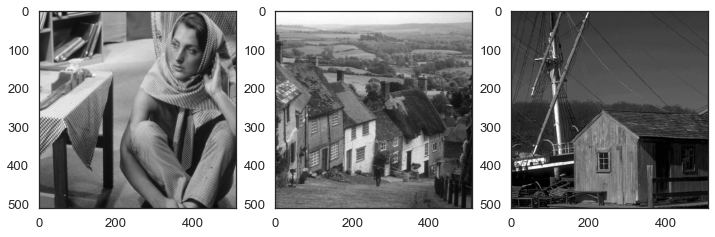

Dimensiones de cada imagen: (512, 512)


In [3]:
# Ejemplo de las imágenes
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i in range(3):
    ax[i].imshow(images_data[i], cmap=plt.cm.gray)
plt.show()

print('Dimensiones de cada imagen:', images_data[1].shape)

#### Parámetros a utilizar
A continuación vamos a definir los valores relacionados al número de imágenes y de parches de cada imagen, así como sus dimensiones:
- $M = 30$ 
- $N = 3$ 
- $l = 32$
- $m = 1000$

In [4]:
# Obtención de las muestras

# Conjunto de entrenamiento
M = 30                # Número de imágenes del conjunto de entrenamiento
I = images_data[0:30] # Conjunto de M imágenes
l = 32                # Dimensión del parche
m = 1000              # Número de parches

#### Obtención de los *m* parches

La siguiente función permite obtener un parche aleatorio de dimensión $l \times l$ de una imagen dada.

In [5]:
# 1) Selecciona un parche de dims lxl al azar
def get_rand_patch(img: np.ndarray, l: int) -> np.ndarray:
    '''Dada una imagen y un valor l, devuelve
    un parche aleatorio de dimensiones lxl'''
    img_x_size = img.shape[0]
    img_y_size = img.shape[0]

    x = np.random.randint(0, img_x_size - l)
    y = np.random.randint(0, img_y_size - l)

    patch = img[x : x + l, y : y + l]
    return patch

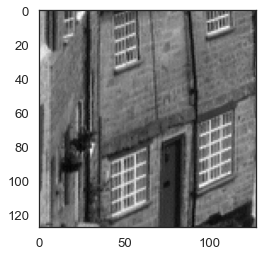

In [6]:
# Ejemplo de obtención de parche aleatorio
plt.imshow(get_rand_patch(I[1], l=128), 
           cmap=plt.cm.gray)

###  2️⃣ Obtención de la matrix *X*
<div style='background-color: #F9E5AB; min-height: 5px'></div>

1) Muestreamos los $M$ parches para obtener una matriz de dimensión $(m, n)$, con $n= l \times l$:

$$ X = \begin{bmatrix} x_1^T \\ x_2^T \\ \vdots \\ x_m^T\end{bmatrix}$$

donde $x_i^T$ es el $i$-ésimo parche formateado como vector (renglón tras renglón) al cual se le restó la media por columnas (datos centrados).

In [7]:
X = np.array([
    get_rand_patch(
        # Obten el parche de lxl de una imagen aleatoria
        images_data[np.random.randint(0, M)], l=l).
        # 'Aplana' (flatten) la matriz
        ravel()
    for j in range(m)
])

# Centraliza la matriz X por variables (pixeles)
col_means = X.mean(axis=0)
X = X - col_means
# Visualiza las dimensiones del dataset
X.shape

(1000, 1024)

### 3️⃣ Calculamos los Componentes Principales de $X$
<div style='background-color: #F9E5AB; min-height: 5px'></div>

Realizaremos este paso mediante la descomposición en valores singulares (**SVD**) de la matriz $X$.

In [8]:
# Realiza la Singular Value Decomposition
V, sing_vals, U = np.linalg.svd(X) 

# Dimensiones de las matrices
print('Dims. de la mtx izquierda:', V.shape)
print('Dims. de los Valores singulares:', sing_vals.shape)
print('Dims. de la mtx derecha:', U.shape)

Dims. de la mtx izquierda: (1000, 1000)
Dims. de los Valores singulares: (1000,)
Dims. de la mtx derecha: (1024, 1024)


### 4️⃣ Selección de los **_K_** primeros eigenvalores
<div style='background-color: #F9E5AB; min-height: 5px'></div>

Sean $\Lambda = diag( \lambda_1, \lambda_2, \ldots \lambda_3)$, con $\lambda_i > \lambda_j$ para $i< j$, los eigenvalores de $X^TX$ y las columnas de $U=[u_1, u_2, \ldots, u_m]$ los eigenvectores correspondientes. Entonces seleccione los primeros $K$ eigenvectores ${u_k}_{k=1, 2, ..., K}$ tal que

$$K = \underset{K}{\operatorname{arg \inf}} \left( \sum_{i=1}^k \lambda_i \geq  \theta \sum_{j=1}^m \lambda_j \right)$$

la suma de los $K$ primeros eigenvalores seleccionados corresponden a al menos la fracción $\theta$ (con $0 < \theta \leq 1$) de la suma de todos los eigenvalores.

#### Obtención de los eigenvalores

a) Obtenemos el vector de **eigenvalores** a partir de los valores singulares teniendo en cuenta que:

$$\Lambda = D^2$$


In [9]:
# Obtención de los eigenvalores a partir de los valores singulares
eig_vals = sing_vals**2

#### Obtención de K eigenvalores dado $\theta$
b)  Función para conservar sólo los primeros K eigenvalores dado un valore de $\theta$

In [10]:
# 2) Selecciona los K primeros eigenvalores
def get_k_eigvals(eig_vals: np.array, 
                  theta: float) -> int:
    '''Devuelve el número de los primeros K 
    eigen valores cuya suma es aproximadamente 
    a la fracción tetha de la suma total de 
    todos lo eigenvalores'''
    umbral = theta * eig_vals.sum()
    K = 0
    suma = 0
    while suma < umbral:
        suma += eig_vals[K]
        K += 1
    return K

### 5️⃣ Matriz de Transformación
<div style='background-color: #F9E5AB; min-height: 5px'></div>

Construimos la matriz de transformación $\tilde U=[u_1, u_2, \ldots, u_K]$

#### Ejemplo usando $\theta = 0.5$

In [11]:
# Selecciona los K primeros eigenvalores
K = get_k_eigvals(eig_vals, theta=0.5)

# Matriz de transformacion Utilde 
# con los primeros K eigenvectores
U_tilde = U[:, 0:K]
print(r'Dims. de U_tilde:', U_tilde.shape)

Dims. de U_tilde: (1024, 1)


### 6️⃣ Codificación del conjunto de imágenes de prueba
<div style='background-color: #F9E5AB; min-height: 5px'></div>

Conjunto de imágenes de prueba ${J}_{i=1, 2, ..., N}$.

- Se eligieron $N=3$ imágenes de prueba a partir `images_data`, dichas imágenes no forman parte del conjunto de entrenamiento.

In [12]:
# Conjunto de imágenes de prueba J
J = images_data[34:37]

- Para el conjunto de imágenes $J$ calculamos los coeficientes ($\beta_i$) en el espacio comprimido para cada bloque ($x_i$) no sobrelapado de $(l \times l$).

$$\beta_i = \tilde U^T x_i$$
> para todo parche $i$ en cada imagen de ${J}$.

- Las siguientes dos funciones auxiliares permiten realizar lo descrito en el punto anterior:
> - `split_image`: Fragmenta la imagen en parches no sobrelapados.
> - `encode_image`: Utiliza la matriz de transformación $\tilde U$ sobre cada parche de la imagen.

In [13]:
# 3) Fragmenta una imagen en parches de lxl
def split_image(img: np.ndarray, l: int) -> List:
    '''Fragmenta la imagen dada en p parches 
    de dimensión lxl y devuelve una lista de éstos'''
    
    x_patches = int(img.shape[0] / l)
    y_patches = int(img.shape[1] / l)
    patches = []
    # Recorre la imagen parche a parche
    for i in range(x_patches):
        for j in range(y_patches):
            patch = img[ (i*l):(i*l)+l, (j*l):(j*l)+l ]
            patches.append(patch)
    return np.array(patches)


# 4) Codifica una imagen por parches, 
# usando la matriz de transformacion
def encode_image(img: np.ndarray, transf_mtx: np.ndarray, 
                 l: int) -> List:
    '''Codifica una imágen usando una matriz 
    de transformación V_tilde'''
    # primero fragmenta la imagen en parches
    patches = split_image(img, l)
    # aplica la transformación a cada parche
    # U_tilde^T · x_i
    betas = [transf_mtx.T.dot(patch.ravel())
                for patch in patches]
    return np.array(betas)

### 7️⃣ Reconstrucción de la imagen
<div style='background-color: #F9E5AB; min-height: 5px'></div>

Reconstruimos la imagen, parche por parche, usando los coeficientes $\beta$.

$$\tilde x_i = \tilde U \beta,$$ 

para todo parche $i$ en cada imagen de ${J}$.

- La siguiente función, `decode_img`, realiza lo indicado en el punto anterior a partir del vector $\beta$ y la matriz de transformación $\tilde U$.

In [14]:
# 5) Decodifica una imagen usando los coeficientes beta
# y la matriz de transformación
def decode_img(betas, transf_mtx, l):
    '''Devuelve una imagen decodificada, parche a parche, a
    partir de una matriz de transformación dada y una lista
    de coef. beta correspondientes al espacio comprimido'''
    # Reconstruye cada parche
    # U_tilde · beta_i
    x_tilde = [ transf_mtx.dot(beta).reshape((l, l)) 
                     for beta in betas ]
    # Reconstruye la imagen usando los parches
    img = np.vstack(
            np.hsplit(
                np.concatenate(
                    x_tilde, axis=1), 
                16)
            )
    return img

### 8️⃣ Ejemplos de las imágenes de prueba
<div style='background-color: #F9E5AB; min-height: 5px'></div>

Mostramos diferentes figuras con ejemplos de parches, imágenes de prueba $J$, sus reconstrucciones $\tilde J$ para distintas selecciones de $\theta$.

In [15]:
# Valores de theta elegidos
thetas = [0.999, 0.95, 0.9, 0.85, 0.8]

- La función `compress_img` **realiza los pasos del 4 al 8**, dados una imagen, la matriz $U$ y un valor de $\theta$.
- La función `show_example` usa a `compress_img` para poder graficar los ejemplos.

In [16]:
def compress_img(img_original: np.ndarray, eig_vals: np.array,
                 theta: float, U: np.ndarray) -> Tuple:
    '''Comprime una imagen dada según 
    el valor theta y la matriz '''
    # Selecciona los primeros K valores singulares
    K = get_k_eigvals(eig_vals, theta=theta)
    # U_tilde con los primeros K eigenvectores
    U_tilde = U.T[:, 0:K]
    # Codifica la imagen original
    betas = encode_image(img_original, U_tilde, l=l)
    # Dcodifica la imagen
    dec_img = decode_img(betas, U_tilde, l=l)
    return dec_img, betas, K
    

def show_example(img_original: np.ndarray, eig_vals: np.array,
                 thetas: List, U: np.ndarray) -> None:
    '''Dada una imagen, un vector de valores theta, y
    una matriz de transformación realiza la comprensión de
    la imagen para cada valor de theta y grafica los resultados'''
    fig, ax = plt.subplots(2, 3, figsize=(16, 12))
    # Imagen original
    i, j = 0, 0
    ax[i, j].imshow(img_original, cmap=plt.cm.gray)
    betas = encode_image(img_original, U, l=l)
    file_size = len(pickle.dumps(betas, -1))/1000
    ax[i, j].set(title='Imagen Original\n' + 
        f'Peso del encode (betas): {file_size} KB')

    for theta in thetas:
        # Para el arreglo de la figura
        j += 1
        if j > 2:
            j, i = 0, 1
        # Comprime la imagen
        dec_img, betas, K = compress_img(img_original, 
                               eig_vals, theta, U)
        # Muestra la imagen
        ax[i, j].imshow(dec_img, cmap=plt.cm.gray) 
        file_size = len(pickle.dumps(betas, -1))/1000
        ax[i, j].set(title=f'theta = {theta}\n' + 
                     f'# eigenvectores: {K}\n' +
                     f'Peso del encode (betas): {file_size} KB') 

#### Ejemplo 1

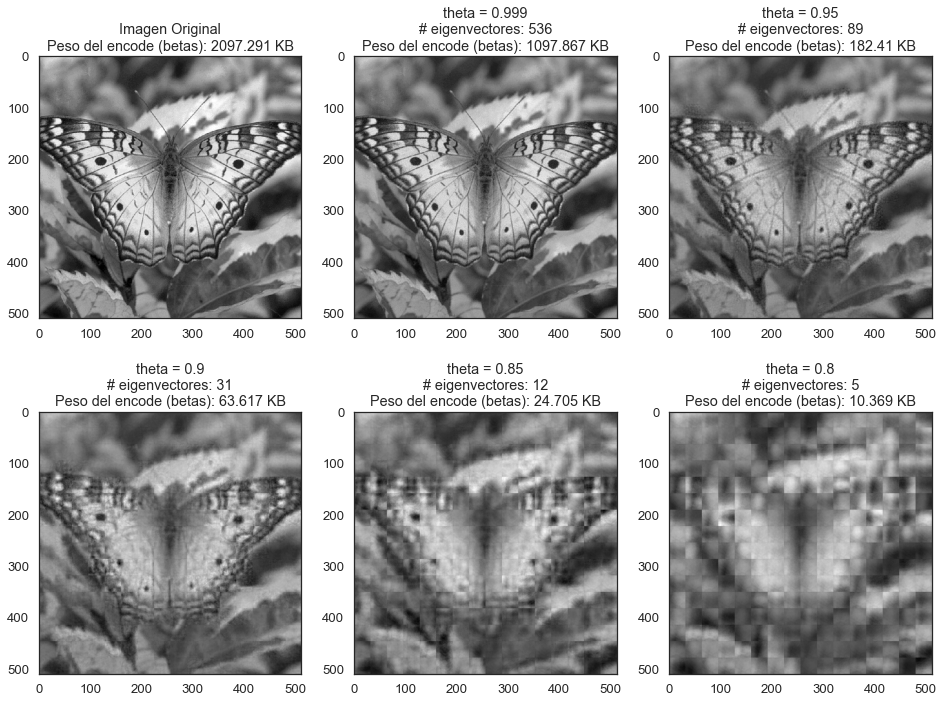

In [17]:
img_original = J[0]
show_example(img_original, eig_vals, thetas, U)

#### Ejemplo 2

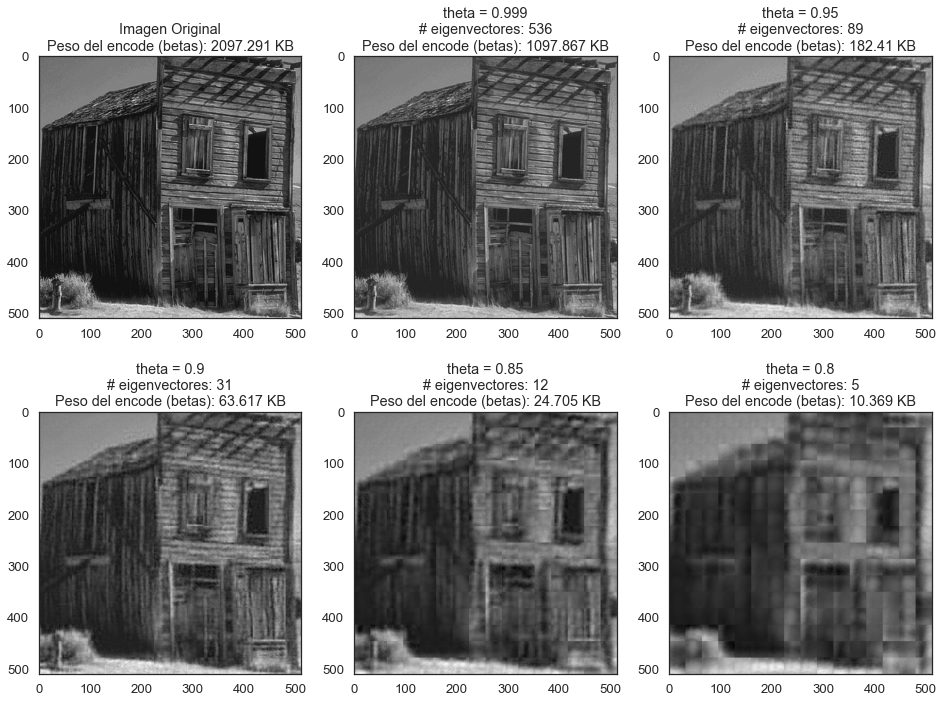

In [18]:
img_original = J[1]
show_example(img_original, eig_vals, thetas, U)

#### Ejemplo 3

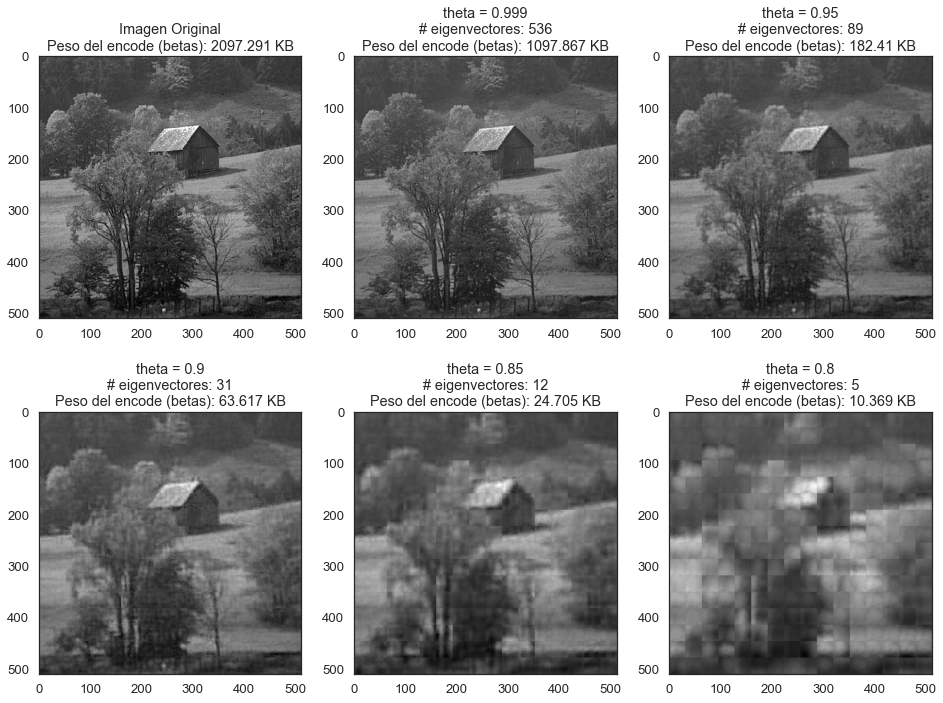

In [19]:
img_original = J[2]
show_example(img_original, eig_vals, thetas, U)

### 9️⃣ Error Absoluto Promedio para un $\theta$ dado
<div style='background-color: #F9E5AB; min-height: 5px'></div>

Genere una gráfica de error absoluto promedio (MAE) vs $\theta$; donde

$$MAE_{\theta} = \frac{1}{N}\sum^N_{i=1} \frac{1}{n}\sum^n_{p=1} \left| J_i(p) - \tilde J_i^{\theta}(p) \right|$$

donde $p$ indica la posición de un pixel, y $\tilde J_i^{\theta}$ es la reconstrucción de la imagen $J_i$ cuando se selecciona la fracción de eigenvectores correspondientes a $\theta$.

In [20]:
def get_mae_img(img_org: np.ndarray, 
            img_rest: np.ndarray) -> float:
    '''Calcula el MAE por cada imagen J_i'''
    J_i = img_org.ravel()
    J_i_tilde = img_rest.ravel()
    n = len(J_i)
    mae = np.sum(np.abs(J_i - J_i_tilde)) / n
    return mae

#### MAE de todo el conjunto de imágenes $J$
Ahora calculamos el MAE tomando en cuenta todas las imágenes del conjunto $J$.

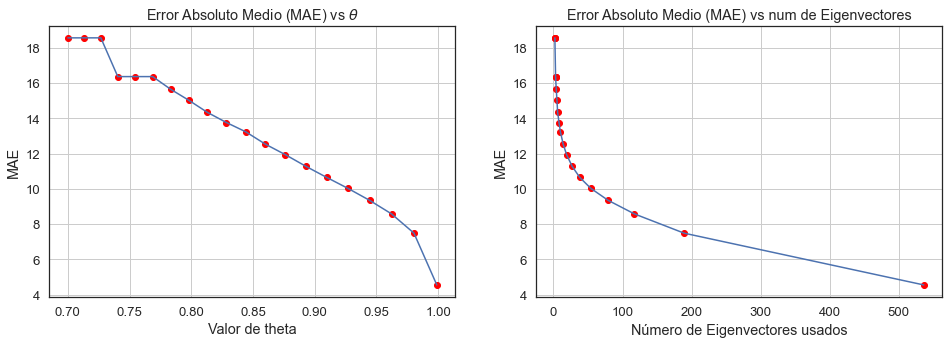

In [21]:
thetas_mae = np.geomspace(0.999, 0.7, 20)
n_eigenvectores = []
errores = []

for theta in thetas_mae:
    mae_J = 0
    for J_i in J:
        # Imagen comprimida
        J_i_tilde, _, K = compress_img(J_i, eig_vals,
                         theta, U)
        mae = get_mae_img(J_i, J_i_tilde)
        mae_J += mae
    mae_J /= len(J)
    errores.append(mae_J)
    n_eigenvectores.append(K)
    
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(thetas_mae, errores)
ax[0].scatter(thetas_mae, errores, c='red')
ax[0].set(title=r'Error Absoluto Medio (MAE) vs $\theta$',
      xlabel='Valor de theta', ylabel='MAE')
ax[0].grid()
ax[1].plot(n_eigenvectores, errores)
ax[1].scatter(n_eigenvectores, errores, c='red')
ax[1].set(title=r'Error Absoluto Medio (MAE) vs num de Eigenvectores',
      xlabel='Número de Eigenvectores usados', ylabel='MAE')
ax[1].grid()
plt.show()

# Implementación con sklearn
A continuación se muestra un ejemplo de la implementación utilizando la librería `sklearn`, y la última imagen (cabaña) de conjunto de prueba $J$.
Para ello se usará un valor de $\theta = 0.85$.

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(0.85).fit(X)
n_components = pca.n_components_
n_components

12

**Imagen de ejemplo:**

In [24]:
img_org = J[2]
l = 32 # Tamaño del parche

Fraccionar la imagen en parches

In [25]:
patchs = split_image(img_org, l=l)

Codificación de los parches

In [26]:
patch_codec = [pca.transform(patch.reshape(1, -1)) 
               for patch in patchs]

Decodificación de los parches

In [27]:
patch_decod = [pca.inverse_transform(patch_c).reshape((32, 32))
               for patch_c in patch_codec]

Ensamble de la imagen restaurada utilizando los parches decodificados.

In [28]:
img_rest = np.vstack(
            np.hsplit(
                np.concatenate(
                    patch_decod, axis=1), 
                int(img_org.shape[0] / l))
            )

## Resultado

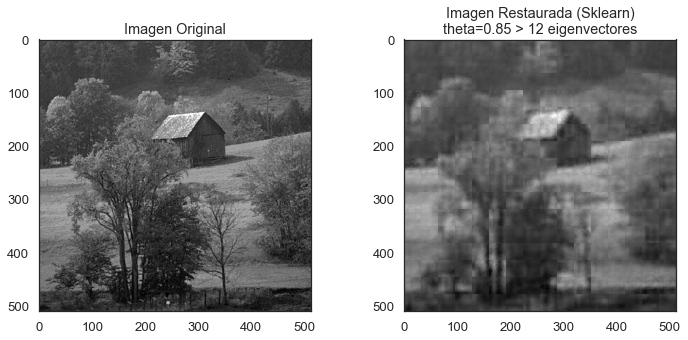

In [29]:
# Muestra la imagen original y la de prueba
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img_org, cmap=plt.cm.gray)
ax[0].set(title='Imagen Original')
ax[1].imshow(img_rest, cmap=plt.cm.gray)
ax[1].set(title='Imagen Restaurada (Sklearn)\ntheta=0.85' + 
          f' > {n_components} eigenvectores')
plt.show()

**La imagen es la misma que la obtenida con la implementación con `numpy`.**

# Referencias

1. Mariano Rivera (2018).
[Análsis de Componentes Principales](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_maquina/pca/pca.html). Consultado el 17 de febrero del 2021.